In [1]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
import glob
import string
import re
import pymorphy3
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


pio.renderers.default = "notebook"  
nltk.download('punkt_tab') 
nltk.download('stopwords') 

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Program\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Program\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("C:\\Users\\Program\\Desktop\\Вариант 3\\Вариант 2\\Petitions.csv")
df

,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство
...,...,...,...
59884,3128111,прошу закрасить граффити,Благоустройство
59885,3276713,Прошу вас отремонтировать пешеходную дорожку,Благоустройство
59886,3274663,Необходимо демонтировать незаконную рекламную ...,Незаконная информационная и (или) рекламная ко...
59887,3359308,Очень гремит на ветру металлическая часть окна...,Кровля


### Предобработка текстовых данных

In [3]:
def remove_punctuation(text): 
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text): 
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text): 
    return re.sub(r'\s+', ' ', text, flags=re.I)

st = '❯\xa0—«»'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [4]:
df['public_petition_text'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(str(text).lower())))) for text in df['public_petition_text']]

df['public_petition_text'][0]

# убрал пунктуацию и сделал lower_case для основного текста статьи


'снег на дороге'

In [5]:
russian_stopwords = stopwords.words('russian') 

def tokenize(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return " ".join(tokens)

In [6]:
df['tokenize_text'] = [tokenize(text) for text in df['public_petition_text']]
df.head()

,id,public_petition_text,reason_category,tokenize_text
0,3168490,снег на дороге,Благоустройство,снег дороге
1,3219678,очистить кабельный киоск от рекламы,Благоустройство,очистить кабельный киоск рекламы
2,2963920,просим убрать все деревья и кустарники которые...,Благоустройство,просим убрать деревья кустарники которые вышли...
3,3374910,неудовлетворительное состояние парадной надпис...,Содержание МКД,неудовлетворительное состояние парадной надпис...
4,3336285,граффити,Благоустройство,граффити


In [7]:
russian_stopwords = stopwords.words('russian') 

def remove_stopwords(text):
    text = [word for word in text if word not in russian_stopwords]
    return text

remove_stopwords(df['tokenize_text'])

df['tokenize_text']


0                                              снег дороге
1                         очистить кабельный киоск рекламы
2        просим убрать деревья кустарники которые вышли...
3        неудовлетворительное состояние парадной надпис...
4                                                 граффити
                               ...                        
59884                             прошу закрасить граффити
59885             прошу отремонтировать пешеходную дорожку
59886    необходимо демонтировать незаконную рекламную ...
59887    очень гремит ветру металлическая часть окна пр...
59888    две проблемы одном незаконные надписи объявлен...
Name: tokenize_text, Length: 59889, dtype: object

In [8]:
stemmer = SnowballStemmer("russian")

stem_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = stemmer.stem(word)
            res.append(p)
        text = " ".join(res)
        stem_list.append(text)
        
    except Exception as e:
        print(e)
        
df['text_stem'] = stem_list

df['text_stem'].head(5)

0                                           снег дорог
1                           очист кабельн киоск реклам
2    прос убра дерев кустарник котор вышл предел га...
3    неудовлетворительн состоян парадн надпис двер ...
4                                              граффит
Name: text_stem, dtype: object

In [9]:
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [10]:
%%time
lemm_texts_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
        
df['text_lemm'] = lemm_texts_list
df['text_lemm'].head(5)

CPU times: total: 1min 4s
Wall time: 1min 4s


0                                          снег дорога
1                     очистить кабельный киоск реклама
2    просить убрать дерево кустарник который выйти ...
3    неудовлетворительный состояние парадный надпис...
4                                             граффити
Name: text_lemm, dtype: object

In [11]:
import re
from collections import Counter

def remove_most_common_words(text, num_words=10):
   
    words = re.findall(r"\b[a-zA-Zа-яА-ЯёЁ]+\b", text.lower())
    
    word_counts = Counter(words)
    
    most_common = [word for word, count in word_counts.most_common(num_words)]
 
    pattern = re.compile(r"\b(" + "|".join(map(re.escape, most_common)) + r")\b", flags=re.IGNORECASE)
    cleaned_text = pattern.sub("", text)
    
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text


df['text_lemm_clear'] = [remove_most_common_words(text, 5) for text in df['text_lemm']]
df['text_stem_clear'] = [remove_most_common_words(text, 5) for text in df['text_stem']]


df.head(10)


,id,public_petition_text,reason_category,tokenize_text,text_stem,text_lemm,text_lemm_clear,text_stem_clear
0,3168490,снег на дороге,Благоустройство,снег дороге,снег дорог,снег дорога,,
1,3219678,очистить кабельный киоск от рекламы,Благоустройство,очистить кабельный киоск рекламы,очист кабельн киоск реклам,очистить кабельный киоск реклама,,
2,2963920,просим убрать все деревья и кустарники которые...,Благоустройство,просим убрать деревья кустарники которые вышли...,прос убра дерев кустарник котор вышл предел га...,просить убрать дерево кустарник который выйти ...,который выйти предел газон пешеходный зона нач...,котор вышл предел газон пешеходн зон начин № №...
3,3374910,неудовлетворительное состояние парадной надпис...,Содержание МКД,неудовлетворительное состояние парадной надпис...,неудовлетворительн состоян парадн надпис двер ...,неудовлетворительный состояние парадный надпис...,этаж,этаж
4,3336285,граффити,Благоустройство,граффити,граффит,граффити,,
5,3130088,необходимо проверить законность установки выве...,Незаконная информационная и (или) рекламная ко...,необходимо проверить законность установки выве...,необходим провер закон установк вывеск фасад м...,необходимо проверить законность установка выве...,фасад мкд адрес проспект непокорённый случай у...,фасад мкд адрес проспект непокорен случа устан...
6,3333526,уборка не производится на лестнице очень грязн...,Содержание МКД,уборка производится лестнице очень грязно этаж...,уборк производ лестниц очен грязн этаж вплот г...,уборка производиться лестница очень грязно эта...,этаж вплоть го звонок жкс дать результат,этаж вплот го звонок жкс дал результат
7,3375258,мусор,Благоустройство,мусор,мусор,мусор,,
8,2982491,отсутствует освещение на лестничной площадке м...,Содержание МКД,отсутствует освещение лестничной площадке этаж...,отсутств освещен лестничн площадк этаж парадн №,отсутствовать освещение лестничный площадка эт...,парадный №,парадн №
9,3375788,зачем было делать благоустройство если никто н...,Благоустройство,делать благоустройство никто убирает мусор еже...,дела благоустройств никт убира мусор ежедневн,делать благоустройство никто убирать мусор еже...,ежедневно,ежедневн


In [ ]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

### Облако слов лемматизированного текста

<Axes: >

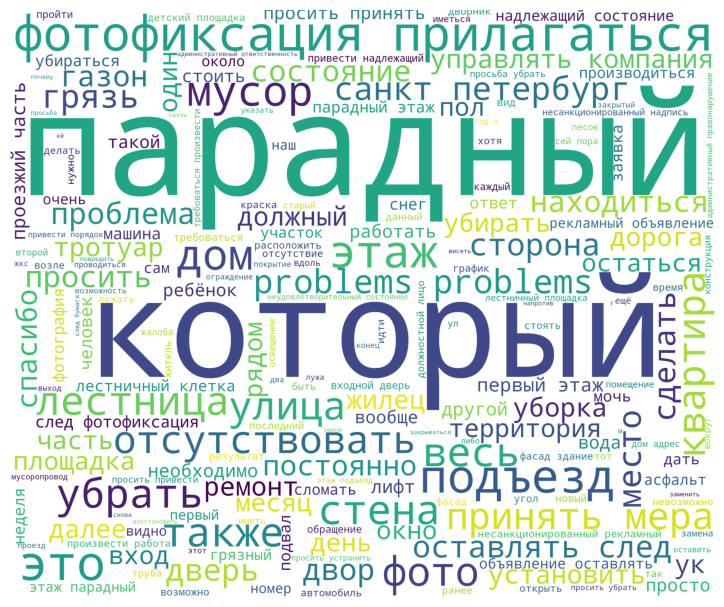

In [13]:
corpus = get_corpus(df['text_lemm_clear'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

### Облако слов стеммингованного текста

<Axes: >

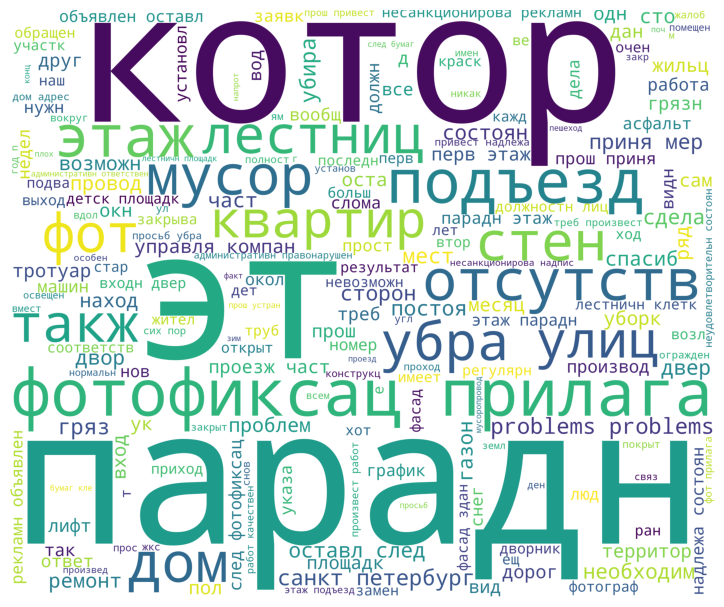

In [14]:
corpus = get_corpus(df['text_stem_clear'].values)
procWordCloud = get_wordCloud(corpus)
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

# Тематическое моделирование

In [15]:
def tokenize2(text):
    if isinstance(text, list):  
        return text  
    if not isinstance(text, str):  
        return []  
    
    tokens = word_tokenize(text.lower(), language='russian')
    tokens = [token for token in tokens 
              if token not in russian_stopwords and len(token) >= 2]
    return tokens  

In [16]:
import gensim

df['text_stem_clear_tokenize'] = [tokenize2(text) for text in df['text_stem_clear']]
df['text_lemm_clear_tokenize'] = [tokenize2(text) for text in df['text_lemm_clear']]


gensim_dictionary1 = gensim.corpora.Dictionary(df['text_lemm_clear_tokenize'])
gensim_dictionary1.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary1.compactify()

gensim_dictionary2 = gensim.corpora.Dictionary(df['text_stem_clear_tokenize'])
gensim_dictionary2.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary2.compactify()


corpus2 = [gensim_dictionary1.doc2bow(text) 
          for text in df['text_lemm_clear_tokenize']]

corpus3 = [gensim_dictionary2.doc2bow(text) 
          for text in df['text_stem_clear_tokenize']]



In [17]:
lda_20 = gensim.models.LdaMulticore(corpus2,num_topics=10,id2word=gensim_dictionary1,passes=10, random_state=6457)

lda_20.print_topics()

[(0,
  '0.030*"требоваться" + 0.027*"problems" + 0.026*"фотофиксация" + 0.025*"прилагаться" + 0.019*"произвести" + 0.017*"просить" + 0.015*"работа" + 0.012*"устранить" + 0.011*"ремонт" + 0.011*"уборка"'),
 (1,
  '0.031*"мусор" + 0.011*"площадка" + 0.010*"просить" + 0.009*"убрать" + 0.009*"уборка" + 0.008*"этаж" + 0.008*"месяц" + 0.008*"лифт" + 0.008*"дом" + 0.008*"просьба"'),
 (2,
  '0.055*"этаж" + 0.040*"парадный" + 0.018*"подъезд" + 0.015*"состояние" + 0.014*"лестница" + 0.011*"стена" + 0.011*"просить" + 0.011*"первый" + 0.010*"дверь" + 0.009*"надлежащий"'),
 (3,
  '0.016*"демонтировать" + 0.016*"установить" + 0.015*"фото" + 0.012*"просить" + 0.010*"просьба" + 0.008*"мера" + 0.007*"пожалуйста" + 0.007*"принять" + 0.007*"случай" + 0.007*"незаконный"'),
 (4,
  '0.023*"дом" + 0.011*"просить" + 0.010*"работа" + 0.009*"состояние" + 0.009*"ремонт" + 0.009*"адрес" + 0.008*"парадный" + 0.008*"место" + 0.008*"часть" + 0.007*"фото"'),
 (5,
  '0.010*"тротуар" + 0.009*"дом" + 0.008*"часть" + 0.0

In [18]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


In [19]:
lda_21 = gensim.models.LdaMulticore(corpus2, 
    num_topics=10, 
    id2word=gensim_dictionary1, 
    passes=10, random_state=6457)


vis_21 = gensimvis.prepare(lda_21, corpus2, gensim_dictionary1)

pyLDAvis.enable_notebook()

# LDA для описания фильмов

In [20]:
vis_21

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.111370 -0.064885       1        1  15.998457
2     -0.042598 -0.084121       2        1  12.535261
5     -0.065001  0.150123       3        1  11.327956
4     -0.003801  0.050918       4        1   9.837904
1     -0.055848 -0.038379       5        1   9.782873
6     -0.116081 -0.080215       6        1   9.591185
9      0.098741  0.169407       7        1   9.226124
0      0.014746  0.015717       8        1   7.747528
8      0.243864 -0.120300       9        1   7.024506
3      0.037348  0.001734      10        1   6.928206, topic_info=              Term         Freq        Total Category  logprob  loglift
12            этаж  2885.000000  2885.000000  Default  30.0000  30.0000
59    фотофиксация  1113.000000  1113.000000  Default  29.0000  29.0000
52     прилагаться  1009.000000  1009.000000  Default  28.0000  28.0000
28        парадный  2692.000000  2692.000000  Default  27.0000  27.0000
622       problems   644.000000   644.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1362    отсутствие    81.743600   331.767850  Topic10  -5.4892   1.2687
132           весь    87.407117   872.720690  Topic10  -5.4222   0.3685
221          новый    82.357217   454.339022  Topic10  -5.4817   0.9618
9          сторона    84.560575  1023.594272  Topic10  -5.4553   0.1760
633          место    82.856921  1044.769284  Topic10  -5.4757   0.1351

[794 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1428      1  0.919941  covid
1428      8  0.043807  covid
934       2  0.013381  gorod
934       3  0.013381  gorod
934       5  0.093670  gorod
...     ...       ...    ...
37        7  0.006080   ящик
37        8  0.042557   ящик
37       10  0.006080   ящик
1753      4  0.030918     №№
1753      9  0.943005     №№

[3510 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 6, 5, 2, 7, 10, 1, 9, 4])

# Оценка CoherenceModel

In [21]:
from gensim.models import CoherenceModel


coherence_model = CoherenceModel(model=lda_20,
    texts=df['text_lemm_clear_tokenize'],
    dictionary=gensim_dictionary1,
    coherence="c_v")

coherence_value = coherence_model.get_coherence()

print(f"Когерентность модели статей: {coherence_value}")



Когерентность модели статей: 0.7721079467347896


# Векторизация 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(df['text_lemm'])

print(vectorizer.vocabulary_)


{'снег': 13812, 'дорога': 3261, 'очистить': 9352, 'кабельный': 4854, 'киоск': 5126, 'реклама': 12844, 'просить': 11968, 'убрать': 15298, 'дерево': 2956, 'кустарник': 5837, 'который': 5602, 'выйти': 2034, 'предел': 11151, 'газон': 2319, 'пешеходный': 9923, 'зона': 4436, 'начинать': 7362, 'подъезд': 10450, 'фасад': 15801, 'дом': 3211, 'сторона': 14430, 'ул': 15460, 'наличный': 7128, 'неудовлетворительный': 7882, 'состояние': 14063, 'парадный': 9465, 'надпись': 7033, 'дверь': 2820, 'этаж': 16785, 'граффити': 2647, 'необходимо': 7628, 'проверить': 11665, 'законность': 3904, 'установка': 15628, 'вывеска': 1958, 'мкд': 6639, 'адрес': 319, 'проспект': 11982, 'непокорённый': 7702, 'случай': 13714, 'установить': 15626, 'незаконно': 7503, 'её': 3517, 'демонтировать': 2936, 'уборка': 15287, 'производиться': 11812, 'лестница': 6008, 'очень': 9344, 'грязно': 2724, 'вплоть': 1784, 'го': 2505, 'звонок': 4354, 'жкс': 3632, 'дать': 2800, 'результат': 12834, 'мусор': 6849, 'отсутствовать': 9251, 'освеще

In [23]:
vectorizer.get_feature_names_out()[10:20]

array(['bceybla', 'be', 'bece', 'bf', 'bfn', 'birthday', 'bobcar',
       'bocejcxxebxcpxkvkvtc', 'cab', 'card'], dtype=object)

In [24]:
from gensim.utils import simple_preprocess

def text_to_vector(text, model):
    words = simple_preprocess(text)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [25]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)

df['text_lemm_clear_str'] = df['text_lemm_clear_tokenize'].apply(' '.join)
df['text_stem_clear_str'] = df['text_stem_clear_tokenize'].apply(' '.join)

count_matrix_lemm = vectorizer.fit_transform(df['text_lemm_clear_str'])
count_matrix_stem = vectorizer.fit_transform(df['text_stem_clear_str'])


count_matrix_lemm.shape

(59889, 53276)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,min_df=0.01, stop_words=russian_stopwords,
    ngram_range=(1,3))



tfidf_matrix_lemm = tfidf_vectorizer.fit_transform(df['text_lemm_clear_str'])
tfidf_matrix_stem = tfidf_vectorizer.fit_transform(df['text_stem_clear_str'])


In [27]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import numpy as np


In [28]:
w2v_model_lemm = Word2Vec(sentences=[text.split() for text in df['text_lemm_clear_str']],
                    vector_size=300, window=5, min_count=10, workers=4)

w2v_model_stem = Word2Vec(sentences=[text.split() for text in df['text_stem_clear_str']],
                    vector_size=300, window=5, min_count=10, workers=4)

w2v_matrix_lemm = np.array([text_to_vector(text, w2v_model_lemm) for text in df['text_lemm_clear_str']])
w2v_matrix_stem = np.array([text_to_vector(text, w2v_model_stem) for text in df['text_stem_clear_str']])


tfidf_matrix_stem.shape

(59889, 53)

In [29]:
print("TF-IDF samples:", tfidf_matrix_lemm.shape[0])
print("Word2Vec samples:", w2v_matrix_lemm.shape[0])

TF-IDF samples: 59889
Word2Vec samples: 59889


## 2d визуализация кластеров 

In [30]:
from sklearn.manifold import TSNE
def plot_tsne_optimized(X, title, texts, perplexity=None, text_length=20):
    """
    Визуализация t-SNE с автоматической настройкой для малых датасетов
    
    Параметры:
        X - матрица признаков (TF-IDF или Word2Vec)
        title - заголовок графика
        texts - список текстов для аннотаций
        perplexity - ручная установка (None для авто)
    """
    n_samples = X.shape[0]
    
    if perplexity is None:
        perplexity = min(5, n_samples - 1)  
    
    if hasattr(X, 'toarray'):
        X = X.toarray()
    
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        random_state=42,
        learning_rate=50, 
        init='pca'  
    )
    
    X_2d = tsne.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.7)
    
    for i, (x, y) in enumerate(X_2d):
        plt.annotate(
            str(texts[i])[:text_length] + ("..." if len(str(texts[i])) > text_length else ""), 
            (x, y),
            fontsize=8,
            alpha=0.8,
            xytext=(10, 10),
            textcoords='offset points'
        )
    
    plt.title(f"{title}\nperplexity={perplexity}, n_samples={n_samples}")
    plt.grid(True, alpha=0.2)
    plt.show()


## Кластеризация Kmeans на основе векторов tfid, countMatrix, word2vec

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=15, random_state=42)

tfid_labels_lemm = kmeans.fit_predict(tfidf_matrix_lemm)  
tfid_labels_stem = kmeans.fit_predict(tfidf_matrix_stem) 

silhouette_tfid_lemm = silhouette_score(tfidf_matrix_lemm, tfid_labels_lemm)
silhouette_tfid_stem = silhouette_score(tfidf_matrix_stem, tfid_labels_stem)

In [33]:
word2vec_labels_lemm = kmeans.fit_predict(w2v_matrix_lemm)  
word2vec_labels_stem = kmeans.fit_predict(w2v_matrix_stem) 

silhouette_word2vec_lemm = silhouette_score(w2v_matrix_lemm, word2vec_labels_lemm)
silhouette_word2vec_stem = silhouette_score(w2v_matrix_stem, word2vec_labels_stem)

# Метрики 

In [34]:
count_matrix_lemm_lables = kmeans.fit_predict(count_matrix_lemm)  
count_matrix_stem_lables = kmeans.fit_predict(count_matrix_stem) 

silhouette_count_matrix_lemm = silhouette_score(count_matrix_lemm, count_matrix_lemm_lables)
silhouette_count_matrix_stem = silhouette_score(count_matrix_stem, count_matrix_stem_lables)

In [35]:
import seaborn as sns
classifiers =["word2vec lemm", "word2vec stem", "count_matrix_lemm", "count_matrix_stem", "tfid_lemm", "tfid_stem"]
log_cols = ["Classifier","Silhoette score"]
log = pd.DataFrame(columns=log_cols)

log["Classifier"] = classifiers
log["Silhoette score"] = [silhouette_word2vec_lemm, silhouette_word2vec_stem, silhouette_count_matrix_lemm, silhouette_count_matrix_stem, silhouette_tfid_lemm, silhouette_tfid_stem]

In [36]:
log

,Classifier,Silhoette score
0,word2vec lemm,0.596531
1,word2vec stem,0.601434
2,count_matrix_lemm,0.574033
3,count_matrix_stem,0.651576
4,tfid_lemm,0.584499
5,tfid_stem,0.599632


<Axes: title={'center': 'Vector'}, xlabel='Silhoette score', ylabel='Classifier'>

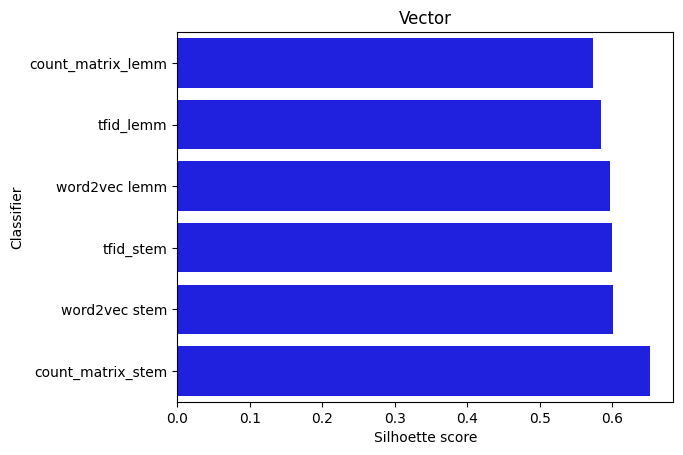

In [37]:

plt.xlabel('Silhoette score')
plt.title('Vector')

sns.barplot(x='Silhoette score', y='Classifier', data=log.sort_values(by='Silhoette score'), color="b")

In [44]:
def fun_punctuation_text(text):
    text = text.lower()
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    text = ''.join([i if not i.isdigit() else '' for i in text])
    text = ''.join([i if i.isalpha() else ' ' for i in text])
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('[a-z]', '', text, flags=re.I)
    st = '❯\xa0'
    text = ''.join([ch if ch not in st else ' ' for ch in text])
    return text
def fun_lemmatizing_text(text):
    tokens = word_tokenize(text)
    res = list()
    for word in tokens:
        p = pymorphy3.MorphAnalyzer(lang='ru').parse(word)[0]
        res.append(p.normal_form)  
    text = " ".join(res)
    return text
def fun_tokenize(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    text = " ".join(tokens)
    return text

def processing(text):
    text = fun_punctuation_text(text)
    text = fun_lemmatizing_text(text)
    text= fun_tokenize(text)
    text_vectorized = vectorizer.transform([text]) 
    return text_vectorized.toarray()

In [41]:
import pickle

with open('model_knn1.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [42]:
import pickle
import joblib
from catboost import CatBoostClassifier
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
with open('model_knn1.pkl', 'rb') as file:
    model = pickle.load(file)

with open('vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

In [ ]:
text = 'Неудовлетворительное состояние парадной - надписи на двери 2 этажа'
prediction = model.predict(processing(text))
distances = kmeans.transform(processing(text))

probabilities = 1 / (distances + 1e-8)  # обратная пропорциональность расстоянию
probabilities /= probabilities.sum(axis=1)[:, np.newaxis]   


15

In [59]:
print(f"Класс: {prediction[0]}")


print(f"Вероятности: {probabilities}")

Класс: 0
Вероятности: [[0.35683505 0.0412204  0.0321106  0.01214719 0.04038167 0.05364732
  0.0383561  0.01652077 0.02523171 0.02570937 0.02122642 0.04341616
  0.03862527 0.02354788 0.23102408]]
